In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import missingno as msno
import plotly.figure_factory as ff
import plotly.graph_objs as go

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, SpectralClustering, MeanShift, KMeans
from sklearn.metrics import silhouette_score

from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.



In [3]:
init_notebook_mode(connected=True)

In [4]:
# Full date range 2 dfs
df1 = pd.read_csv('/Users/alentersakyan/Downloads/online_retail_1011.csv')
df2 = pd.read_csv('/Users/alentersakyan/Downloads/OnlineRetail_0910.csv')

# Concat them
df = pd.concat([df1,df2])
#df.shape

In [5]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


# EDA/ Cleaning

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1067371 entries, 0 to 525460
Data columns (total 8 columns):
Invoice        1067371 non-null object
StockCode      1067371 non-null object
Description    1062989 non-null object
Quantity       1067371 non-null int64
InvoiceDate    1067371 non-null object
Price          1067371 non-null float64
Customer ID    824364 non-null float64
Country        1067371 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 73.3+ MB


In [7]:
df.describe()

,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


### Look for null values
- For RFM these matter, but for time series by day this shouldnt matter
- TS will be grouped by day/ total sale for the day

In [8]:
print((df['Customer ID'].isnull()).any())
df[df['Customer ID'].isnull()]

True


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
622,536414,22139,NaN,56,12/1/10 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/10 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/10 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/10 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/10 14:32,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
525231,538159,21324,NaN,-18,12/9/10 17:17,0.00,NaN,United Kingdom
525232,538158,20892,NaN,-32,12/9/10 17:17,0.00,NaN,United Kingdom
525233,538160,20956,NaN,288,12/9/10 17:18,0.00,NaN,United Kingdom
525234,538161,46000S,Dotcom sales,-100,12/9/10 17:25,0.00,NaN,United Kingdom


In [9]:
# Drop nulls-- looks like about 240k nulls for customer ID. Can't impute there so need to delete
df.dropna(inplace=True)

In [10]:
# Remove negative quantity (cancelled or returned?)
df = df[df.Quantity > 0]

In [11]:
df.shape

(805620, 8)

In [15]:
# Unique values of each col
print("Unique values for Invoice: {}".format(df['Invoice'].nunique()))
print("Unique values for StockCode: {}".format(df['StockCode'].nunique()))
print("Unique values for CustomerID: {}".format(df['Customer ID'].nunique()))

Unique values for Invoice: 36975
Unique values for StockCode: 4631
Unique values for CustomerID: 5881


### Date modifications

#### Invoice dates

In [16]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceDate'].head()

0   2010-12-01 08:26:00
1   2010-12-01 08:26:00
2   2010-12-01 08:26:00
3   2010-12-01 08:26:00
4   2010-12-01 08:26:00
Name: InvoiceDate, dtype: datetime64[ns]

In [17]:
# Date range for invoices is December 1, 2010 - December 9, 2011
df['InvoiceDate'].describe()

count                  805620
unique                  34591
top       2011-11-14 15:27:00
freq                      542
first     2009-12-01 07:45:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

In [18]:
# # Create columns for day, month, year from datetime. Also get a truncated date (no time)
# df['datetruncated'] = df['InvoiceDate']
# df['Year'] = df['InvoiceDate'].dt.year
# df['Month'] = df['InvoiceDate'].dt.month
# df['Day'] = df['InvoiceDate'].dt.day
# df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek
# # The day of the week with Monday=0, Sunday=6.

In [19]:
# Get a truncated version of the date-- only year/month
def get_month(x): 
    return pd.datetime(x.year, x.month, 1)

In [20]:
# Get a truncated version of the InvoiceDate and apply the day to 1. This now represents the first month they purchased
df['InvoiceMonth'] = df['InvoiceDate'].apply(get_month)
df['InvoiceMonth'].head()

0   2010-12-01
1   2010-12-01
2   2010-12-01
3   2010-12-01
4   2010-12-01
Name: InvoiceMonth, dtype: datetime64[ns]

In [21]:
# def truncate_date(x):
#     return pd.datetime(x.year, x.month, x.day)

In [22]:
# # Get truncated date with actual day (not just 1 like above)
# df['InvoiceDay'] = df['InvoiceDate'].apply(truncate_date)
# df['InvoiceDay']

In [23]:
(df['Customer ID'].isnull()).any()

False

In [24]:
# (df['InvoiceDay'].isnull()).any()

#### Cohort Month

In [25]:
# Group by CustomerID and select the InvoiceDay value
gb_customerID = df.groupby('Customer ID')['InvoiceMonth'] 

# Assign a minimum InvoiceMonth value to the dataset--> month of first purchase for that customer
df['CohortMonth'] = gb_customerID.transform('min')
df['CohortMonth']

0        2009-12-01
1        2009-12-01
2        2009-12-01
3        2009-12-01
4        2009-12-01
            ...    
525456   2009-12-01
525457   2009-12-01
525458   2009-12-01
525459   2009-12-01
525460   2009-12-01
Name: CohortMonth, Length: 805620, dtype: datetime64[ns]

In [26]:
# import pickle
# with open ('df_online_retail_cleaned.pickle', 'wb') as to_write:
#     pickle.dump(df, to_write)
    
# # # To load pickle back in
# # with open('df_cleaned.pickle','rb') as read_file:
# #     df = pickle.load(read_file)

# EDA further explore
- Add some plotting

In [27]:
df.StockCode.describe()

count     805620
unique      4631
top       85123A
freq        5188
Name: StockCode, dtype: object

In [28]:
df[df.StockCode == '85123A'].InvoiceDate.describe()

count                    5188
unique                   4851
top       2011-07-19 13:01:00
freq                        4
first     2009-12-01 09:46:00
last      2011-12-09 11:34:00
Name: InvoiceDate, dtype: object

In [29]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country', 'InvoiceMonth', 'CohortMonth'],
      dtype='object')

In [30]:
df.describe()

,Quantity,Price,Customer ID
count,805620.000000,805620.000000,805620.000000
mean,13.307665,3.206279,15331.856250
std,144.306739,29.197901,1696.768395
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,13982.000000
50%,5.000000,1.950000,15271.000000
75%,12.000000,3.750000,16805.000000
max,80995.000000,10953.500000,18287.000000


In [31]:
# Most popular item by quantity purchased (in a single invoice)
df.sort_values('Quantity', ascending=False)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,InvoiceMonth,CohortMonth
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,2011-12-01,2011-05-01
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,2011-01-01,2009-12-01
90857,497946,37410,BLACK AND WHITE PAISLEY FLOWER MUG,19152,2010-02-15 11:57:00,0.10,13902.0,Denmark,2010-02-01,2009-12-01
127168,501534,21091,SET/6 WOODLAND PAPER PLATES,12960,2010-03-17 13:09:00,0.10,13902.0,Denmark,2010-03-01,2009-12-01
127166,501534,21099,SET/6 STRAWBERRY PAPER CUPS,12960,2010-03-17 13:09:00,0.10,13902.0,Denmark,2010-03-01,2009-12-01
...,...,...,...,...,...,...,...,...,...,...
386457,570235,23393,HOME SWEET HOME CUSHION COVER,1,2011-10-09 14:30:00,3.75,13193.0,United Kingdom,2011-10-01,2011-10-01
386456,570235,22295,HEART FILIGREE DOVE LARGE,1,2011-10-09 14:30:00,1.65,13193.0,United Kingdom,2011-10-01,2011-10-01
386455,570235,21671,RED SPOT CERAMIC DRAWER KNOB,1,2011-10-09 14:30:00,1.45,13193.0,United Kingdom,2011-10-01,2011-10-01
386454,570235,23032,DRAWER KNOB CRACKLE GLAZE IVORY,1,2011-10-09 14:30:00,1.65,13193.0,United Kingdom,2011-10-01,2011-10-01


In [32]:
# Most popular item overall
gb_stockcode = df.groupby('StockCode')['Quantity'].sum()
print(gb_stockcode.nlargest(10))

StockCode
84077     109169
85099B     94983
85123A     93697
21212      91263
23843      80995
84879      79913
22197      77971
23166      77916
17003      71129
21977      55270
Name: Quantity, dtype: int64


In [33]:
# Most purchased item across two years:
df[df['StockCode'] == '84077'] # WW2 gliders asstd designs

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,InvoiceMonth,CohortMonth
3259,536615,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,48,2010-12-02 10:09:00,0.29,14047.0,United Kingdom,2010-12-01,2010-02-01
3286,536618,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,48,2010-12-02 10:17:00,0.29,17017.0,United Kingdom,2010-12-01,2009-12-01
4945,536830,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,2880,2010-12-02 17:38:00,0.18,16754.0,United Kingdom,2010-12-01,2010-03-01
5047,536839,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,288,2010-12-02 18:25:00,0.21,15093.0,United Kingdom,2010-12-01,2009-12-01
5278,536856,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,48,2010-12-03 10:26:00,0.29,13370.0,United Kingdom,2010-12-01,2010-12-01
...,...,...,...,...,...,...,...,...,...,...
520117,537689,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,48,2010-12-08 10:36:00,0.29,15750.0,United Kingdom,2010-12-01,2009-12-01
520262,537707,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,48,2010-12-08 10:53:00,0.29,14032.0,United Kingdom,2010-12-01,2009-12-01
520558,537771,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,48,2010-12-08 12:29:00,0.29,15498.0,United Kingdom,2010-12-01,2009-12-01
522277,537852,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,96,2010-12-08 15:56:00,0.29,17340.0,United Kingdom,2010-12-01,2010-02-01


### Revenue column

In [34]:
df['Revenue'] = df['Price'] * df['Quantity']
df['Revenue']

0         15.30
1         20.34
2         22.00
3         20.34
4         20.34
          ...  
525456     5.90
525457     3.75
525458     3.75
525459     7.50
525460     3.90
Name: Revenue, Length: 805620, dtype: float64

# Cohort Analysis

#### Create 6 dif variables for invoice/cohort year, month, day

In [35]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

In [36]:
invoice_year, invoice_month, _ = get_date_int(df, 'InvoiceMonth')

In [37]:
cohort_year, cohort_month, _ = get_date_int(df, 'CohortMonth')

In [38]:
df.head(2)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,InvoiceMonth,CohortMonth,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2009-12-01,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2009-12-01,20.34


In [42]:
cohort_month

0         12
1         12
2         12
3         12
4         12
          ..
525456    12
525457    12
525458    12
525459    12
525460    12
Name: CohortMonth, Length: 805620, dtype: int64

In [40]:
invoice_month

0         12
1         12
2         12
3         12
4         12
          ..
525456    12
525457    12
525458    12
525459    12
525460    12
Name: InvoiceMonth, Length: 805620, dtype: int64

In [43]:
# Use the variables above to calculate difs from invoice date to cohort start
# Cohort start is when that cohort started buying

# Calculate difference in years
years_diff = invoice_year - cohort_year

# Calculate difference in months
months_diff = invoice_month - cohort_month

# # Calculate difference in days
# days_diff = invoice_day - cohort_day

# Extract the dif in months from all previous values to get a total month dif for cohortindex
df['CohortIndex'] = years_diff * 12 + months_diff + 1 # +1 so first month is 1 not 0

#### Count of monthly active custoemrs from each cohort

In [44]:
grouping = df.groupby(['CohortMonth', 'CohortIndex'])

In [45]:
cohort_data = grouping['Customer ID'].apply(pd.Series.nunique) # Count unique customers in each group

In [46]:
cohort_data

CohortMonth  CohortIndex
2009-12-01   1              955
             2              337
             3              319
             4              406
             5              363
                           ... 
2011-10-01   2               71
             3               35
2011-11-01   1              192
             2               27
2011-12-01   1               28
Name: Customer ID, Length: 325, dtype: int64

In [47]:
# Reset index
c = cohort_data.reset_index()
c

In [49]:
cohort_counts = c.pivot(index='CohortMonth',
                                 columns='CohortIndex',
                                 values='Customer ID') #Customer COUNTS not ID

#### Retention

In [50]:
# Retention table-- how many customers from each cohort return in later months
cohort_sizes = cohort_counts.iloc[:,0] # First row of cohort_counts

# Divide all values in cohort_counts table by cohort_sizes to get retention from start
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.round(3)*100

# Show retention
retention.head(10)

CohortIndex,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
CohortMonth,,,,,,,,,,,,,,,,,,,,,
2009-12-01,1.0,0.352880,0.334031,0.425131,0.380105,0.359162,0.376963,0.342408,0.336126,0.362304,...,0.302618,0.262827,0.302618,0.282723,0.259686,0.255497,0.315183,0.304712,0.407330,0.196859
2010-01-01,1.0,0.206266,0.310705,0.305483,0.263708,0.300261,0.258486,0.229765,0.279373,0.318538,...,0.151436,0.234987,0.198433,0.185379,0.195822,0.242820,0.193211,0.245431,0.057441,NaN
2010-02-01,1.0,0.236702,0.223404,0.289894,0.244681,0.199468,0.191489,0.284574,0.252660,0.273936,...,0.199468,0.159574,0.162234,0.143617,0.228723,0.228723,0.162234,0.058511,NaN,NaN
2010-03-01,1.0,0.189616,0.230248,0.241535,0.232506,0.203160,0.246050,0.302483,0.275395,0.108352,...,0.169300,0.173815,0.155756,0.176072,0.200903,0.212190,0.079007,NaN,NaN,NaN
2010-04-01,1.0,0.193878,0.193878,0.163265,0.183673,0.224490,0.275510,0.261905,0.105442,0.108844,...,0.156463,0.139456,0.149660,0.180272,0.224490,0.057823,NaN,NaN,NaN,NaN
2010-05-01,1.0,0.157480,0.169291,0.173228,0.177165,0.255906,0.212598,0.125984,0.059055,0.082677,...,0.125984,0.137795,0.165354,0.153543,0.047244,NaN,NaN,NaN,NaN,NaN
2010-06-01,1.0,0.174074,0.188889,0.203704,0.229630,0.285185,0.125926,0.088889,0.081481,0.118519,...,0.122222,0.133333,0.203704,0.051852,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-01,1.0,0.155914,0.182796,0.295699,0.290323,0.139785,0.112903,0.145161,0.145161,0.112903,...,0.172043,0.236559,0.080645,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-01,1.0,0.203704,0.296296,0.320988,0.172840,0.117284,0.098765,0.123457,0.135802,0.129630,...,0.197531,0.067901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Sum of revenue for cohorts across time

In [51]:
# Gb cohortmonth + cohortindex
grouping = df.groupby(['CohortMonth', 'CohortIndex'])

In [52]:
# Sum of revenue
cohort_rev = grouping['Revenue'].sum()

# Reset index for pivot
c_rev = cohort_rev.reset_index()

# Creeate pivot
sum_revenue = c_rev.pivot_table(index='CohortMonth',
                                   columns='CohortIndex',
                                   values='Revenue')

#### Visualize cohort analysis

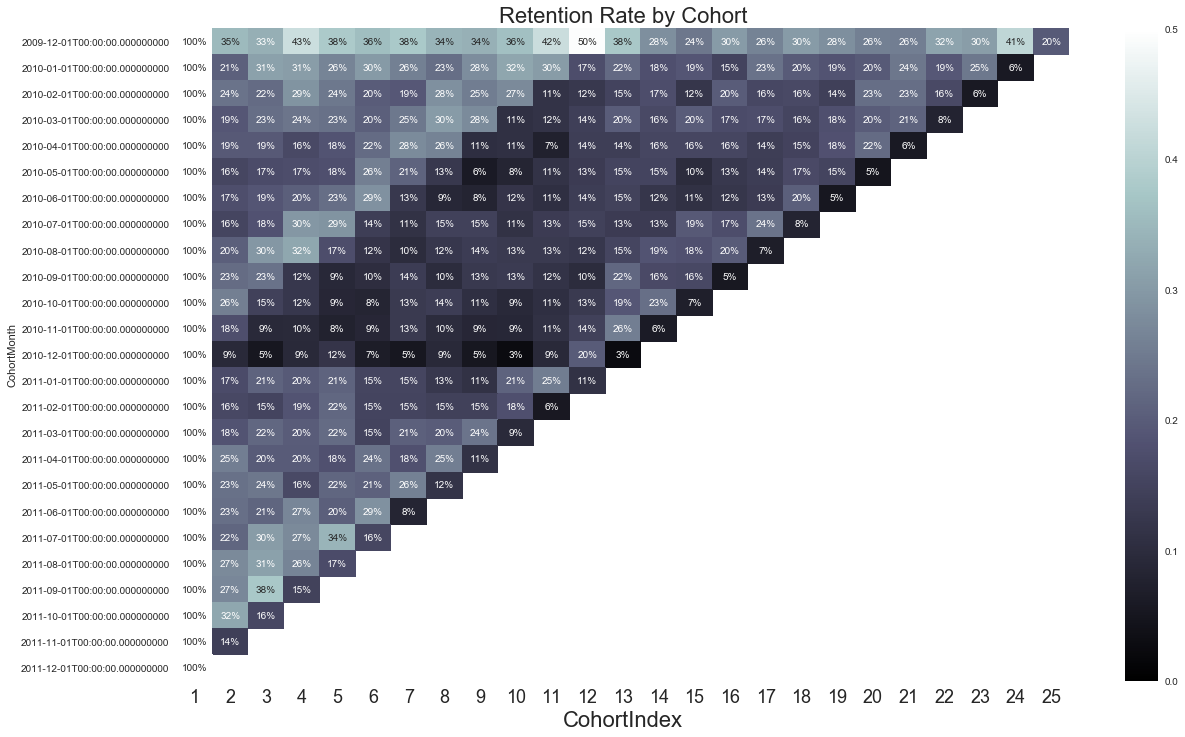

In [53]:
# Sum of revenue per month by cohort
plt.figure(figsize=(20,12))
plt.title("Retention Rate by Cohort", fontsize=22)
plt.xticks(fontsize=18)
plt.xlabel('Cohort Index', fontsize=22)
sns.heatmap(data=retention, annot=True, cmap='bone', fmt='.0%',vmin=0.0, vmax=0.5);

plt.savefig('retention_diagram.png')

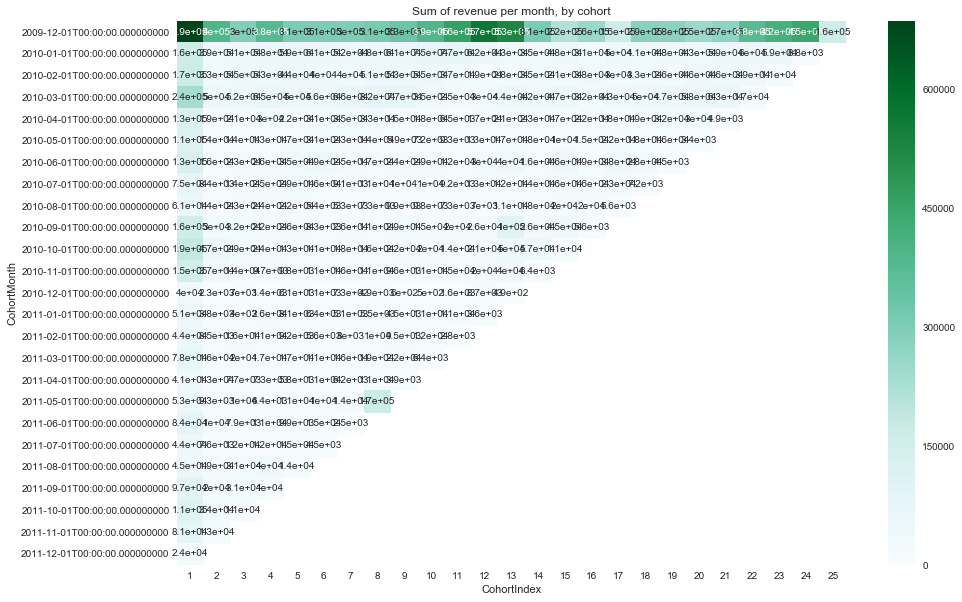

In [54]:
# Sum of revenue per month by cohort
plt.figure(figsize=(15,10))
plt.title("Sum of revenue per month, by cohort")
sns.heatmap(data=sum_revenue, annot=True, cmap='BuGn')

# Pickle cleaned df

In [55]:
with open ('df_cleaned.pickle', 'wb') as to_write:
    pickle.dump(df, to_write)

In [56]:
df.shape

(805620, 12)

# RFM
- Using quartile. One RFM score for whole year

In [57]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country', 'InvoiceMonth', 'CohortMonth',
       'Revenue', 'CohortIndex'],
      dtype='object')

In [58]:
rfm_df = df[['Customer ID', 'Invoice', 'Quantity', 'InvoiceDate', 'Price', 'Revenue']]

In [59]:
rfm_df = rfm_df[rfm_df['Price'] > 0]

### Recency

In [60]:
# Recency. Set End of Year date to calc recency.
eoy_date = pd.datetime(2011,12,11)
eoy_date

datetime.datetime(2011, 12, 11, 0, 0)

In [61]:
# Groupby Customer ID + get most recent/max invoice date
recency_data = rfm_df.groupby('Customer ID', as_index=False)['InvoiceDate'].max()
recency_data.columns= ['Customer ID', 'Last_Purchase_Date']
recency_data.head()

,Customer ID,Last_Purchase_Date
0,12346.0,2011-01-18 10:01:00
1,12347.0,2011-12-07 15:52:00
2,12348.0,2011-09-25 13:13:00
3,12349.0,2011-11-21 09:51:00
4,12350.0,2011-02-02 16:01:00


In [62]:
# From the gb above, create new col with days since eoy to last purchase date in days
recency_data['Recency'] = recency_data['Last_Purchase_Date'].apply(lambda x: (eoy_date - x).days)
recency_data.drop('Last_Purchase_Date', axis=1,inplace=True)
recency_data.head()

,Customer ID,Recency
0,12346.0,326
1,12347.0,3
2,12348.0,76
3,12349.0,19
4,12350.0,311


### Frequency
- Can't just apply a count on invoice number by customer ID because that counts total invoices, not unique

In [63]:
frequency = rfm_df.groupby('Customer ID', as_index=False).agg({'Invoice': 'nunique'})
frequency.head()

,Customer ID,Invoice
0,12346.0,12
1,12347.0,8
2,12348.0,5
3,12349.0,4
4,12350.0,1


### Monetary

In [64]:
monetary = rfm_df.groupby('Customer ID', as_index=False)['Revenue'].sum()
monetary.head()

,Customer ID,Revenue
0,12346.0,77556.46
1,12347.0,5633.32
2,12348.0,2019.40
3,12349.0,4428.69
4,12350.0,334.40


In [65]:
monetary.Revenue.describe()

count      5878.000000
mean       3018.616737
std       14737.731040
min           2.950000
25%         348.762500
50%         898.915000
75%        2307.090000
max      608821.650000
Name: Revenue, dtype: float64

### Combine R,F,M series into one RFM table

In [66]:
rfm_table = recency_data.merge(frequency.merge(monetary,on='Customer ID'),on='Customer ID')

In [67]:
# Rename columns
rfm_table.rename(columns={'Customer ID': 'Customer ID', 'Recency': 'Recency', 'Invoice':'Frequency',\
                          'Revenue': 'Monetary'}, inplace=True)
rfm_table.head()

,Customer ID,Recency,Frequency,Monetary
0,12346.0,326,12,77556.46
1,12347.0,3,8,5633.32
2,12348.0,76,5,2019.40
3,12349.0,19,4,4428.69
4,12350.0,311,1,334.40


## RFM quartile calcs

In [68]:
# Recency quartile-- backwards coded because high recency is bad
recency_labels = list(range(4, 0, -1)) # Backwards step w/ -1
recency_quartile = pd.qcut(rfm_table['Recency'], q=4, labels=recency_labels)

In [69]:
# Frequency quartile
#frequency_quartile = pd.qcut(rfm_table['Frequency'], q=4, labels=range(1,5)) # Didn't work this way..
frequency_quartile = pd.qcut(rfm_table['Frequency'], q=5, duplicates='drop', labels=range(1,5))

In [70]:
# Monetary quartile
monetary_quartile = pd.qcut(rfm_table['Monetary'], q=4, labels=range(1,5))

In [71]:
# Turn quartiles into columns
rfm_table['R'] = recency_quartile
rfm_table['F'] = frequency_quartile
rfm_table['M'] = monetary_quartile

In [72]:
# RFM total
def rfm_join(x):
    ''' Concats the R,F, and M cols '''
    return str(x['R']) + str(x['F']) + str(x['M']) 

In [73]:
rfm_table['RFM_total'] = rfm_table.apply(rfm_join, axis=1)

In [74]:
rfm_table['RFM_score'] = rfm_table[['R','F','M']].sum(axis=1)

In [75]:
rfm_table.head()

,Customer ID,Recency,Frequency,Monetary,R,F,M,RFM_total,RFM_score
0,12346.0,326,12,77556.46,2,4,4,244,10.0
1,12347.0,3,8,5633.32,4,3,4,434,11.0
2,12348.0,76,5,2019.40,3,3,3,333,9.0
3,12349.0,19,4,4428.69,4,2,4,424,10.0
4,12350.0,311,1,334.40,2,1,1,211,4.0


### Look into RFM segments via RFM total
- Later will give names to these dif segments to help presentation
- E.g 111 = worst/lost customers, 444 = best customers....SEE RFM ideas online

In [76]:
# Worst customers
rfm_table[rfm_table['RFM_total'] == '111'].head()

,Customer ID,Recency,Frequency,Monetary,R,F,M,RFM_total,RFM_score
40,12387.0,416,1,143.94,1,1,1,111,3.0
45,12392.0,592,1,234.75,1,1,1,111,3.0
53,12400.0,415,1,205.25,1,1,1,111,3.0
57,12404.0,683,1,63.24,1,1,1,111,3.0
64,12411.0,410,1,346.90,1,1,1,111,3.0


In [77]:
# Best customers
rfm_table[rfm_table['RFM_total'] == '444'].head()

,Customer ID,Recency,Frequency,Monetary,R,F,M,RFM_total,RFM_score
16,12362.0,4,11,5356.23,4,4,4,444,12.0
34,12380.0,22,11,9676.30,4,4,4,444,12.0
48,12395.0,20,15,5067.27,4,4,4,444,12.0
68,12415.0,25,28,144458.37,4,4,4,444,12.0
70,12417.0,4,20,6816.91,4,4,4,444,12.0


### Comparison of RFM_total groups (3-12)
- Examine difs in means of Recency, Frequency, and Monetary for each of the segments of RFM_total

In [78]:
rfm_table['M'] = rfm_table['M'].astype('int64', inplace=True)
rfm_table['F'] = rfm_table['F'].astype('int64', inplace=True)
rfm_table['R'] = rfm_table['R'].astype('int64', inplace=True)

In [79]:
gb_rfm = rfm_table.groupby('RFM_score').agg({'Recency': 'mean', 'Frequency': 'mean', 'Monetary': ['mean','count']})
gb_rfm

Recency  Frequency      Monetary      
                 mean       mean          mean count
RFM_score                                           
3.0        541.492497   1.140518    186.179550   733
4.0        370.362093   1.366337    354.539082   707
5.0        247.698891   1.809826    531.068605   631
6.0        185.164179   2.288060    817.825301   670
7.0        152.866667   3.326496   1095.501937   585
8.0        115.543278   4.327808   1594.152468   543
9.0         87.875789   5.894737   2603.933752   475
10.0        63.420082   8.733607   3788.069826   488
11.0        36.273731  12.240618   5643.234417   453
12.0        10.397976  26.288364  15725.005015   593

# Clustering prep
- Kmeans to start, then maybe others

In [80]:
rfm_table.describe()

,Customer ID,Recency,Frequency,Monetary,R,F,M,RFM_score
count,5878.000000,5878.000000,5878.000000,5878.000000,5878.000000,5878.000000,5878.000000,5878.000000
mean,15315.313542,201.866791,6.289384,3018.616737,2.504764,2.122661,2.500000,7.127424
std,1715.572666,209.353961,13.009406,14737.731040,1.120399,1.168220,1.118281,2.919648
min,12346.000000,1.000000,1.000000,2.950000,1.000000,1.000000,1.000000,3.000000
25%,13833.250000,26.000000,1.000000,348.762500,2.000000,1.000000,1.250000,5.000000
50%,15314.500000,96.000000,3.000000,898.915000,3.000000,2.000000,2.500000,7.000000
75%,16797.750000,380.000000,7.000000,2307.090000,4.000000,3.000000,3.750000,10.000000
max,18287.000000,739.000000,398.000000,608821.650000,4.000000,4.000000,4.000000,12.000000


In [81]:
# Copy the rfm table for later clustering. Will remove outliers for kmeans and keep for dbscan
dbscan_rfm_table = rfm_table.copy()

In [82]:
rfm_table.Frequency.quantile(.9999)

361.5625999999411

In [83]:
rfm_table.set_index('Customer ID',inplace=True)

### Outliers / transform features

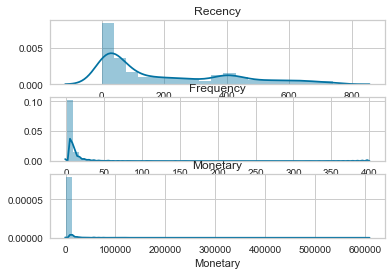

In [84]:
# Plot dists
plt.subplot(3, 1, 1); sns.distplot(rfm_table['Recency'])
plt.title("Recency")
plt.subplot(3, 1, 2); sns.distplot(rfm_table['Frequency'])
plt.title("Frequency")
plt.subplot(3, 1, 3); sns.distplot(rfm_table['Monetary'])
plt.title("Monetary");

In [85]:
# Remove outliers for Frequency (~ 1%)
rfm_table = rfm_table[rfm_table.Frequency < 50]


In [86]:
# # Log transform R and M so they are not as skewed
rfm_table['log_recency'] = np.log(rfm_table['Recency'])
#rfm_table['log_frequency'] = np.log(rfm_table['Frequency'])
rfm_table['log_monetary'] = np.log(rfm_table['Monetary'])

Text(0.5, 1.0, 'Log Monetary')

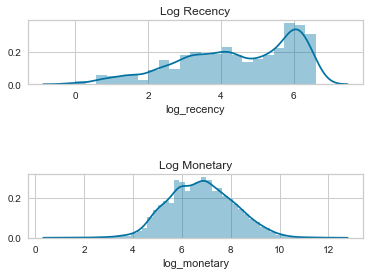

In [87]:
# Plot logged dists
plt.subplot(3, 1, 1); sns.distplot(rfm_table['log_recency'])
plt.title("Log Recency")
#plt.subplot(3, 1, 2); sns.distplot(rfm_table['log_frequency'])
#plt.title("Log Frequency")
plt.subplot(3, 1, 3); sns.distplot(rfm_table['log_monetary'])
plt.title("Log Monetary")

In [88]:
kmeans_rfm_table = rfm_table[['log_monetary', 'log_recency', 'Frequency']]

### Standarize features

In [89]:
scaler = StandardScaler()
scaled_rfm_table = scaler.fit_transform(kmeans_rfm_table)
scaled_rfm_df = pd.DataFrame(data=scaled_rfm_table, index=kmeans_rfm_table.index, columns=kmeans_rfm_table.columns)

In [91]:
# Confirm scaling-- mean should be about 0 and std about 1
print(scaled_rfm_df.mean(axis=0))
print(scaled_rfm_df.std(axis=0))

log_monetary   -3.745859e-16
log_recency    -2.464070e-16
Frequency       3.922191e-18
dtype: float64
log_monetary    1.000086
log_recency     1.000086
Frequency       1.000086
dtype: float64


In [92]:
scaled_rfm_df.columns

Index(['log_monetary', 'log_recency', 'Frequency'], dtype='object')

# K means

### Yellowbrick silhouette visuals
- +1 = good separation, -1 = bad / possibly wrong

In [96]:
# Instantiate the clustering model and visualizer
model = KMeans(3, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.



SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x1c1c54b9b0>,
                     colors='yellowbrick', is_fitted='auto', model=None)

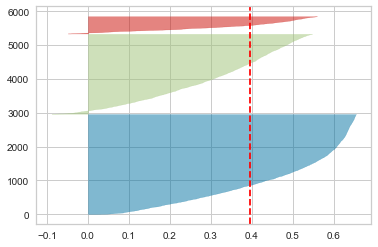

In [97]:
visualizer.fit(scaled_rfm_df)

### Yellowbrick elbow
- Where the plot 'elbows' / corners is the best k
- Here it looks like 3/4 is best

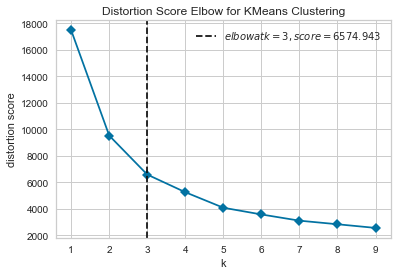

In [98]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10),timings=False)

visualizer.fit(scaled_rfm_df)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [99]:
visualizer.elbow_value_

3

# KMeans Sklearn
- Will use 3 - 4 clusters based on scores above

### 3 Cluster K Means

In [100]:
kmeans = KMeans(n_clusters=3, random_state=44)
kmeans.fit(scaled_rfm_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=44, tol=0.0001, verbose=0)

In [101]:
cluster_labels = kmeans.labels_

In [102]:
# Create column with each customer's cluster #
scaled_rfm_df_k3 = scaled_rfm_df.assign(cluster_no = cluster_labels)
scaled_rfm_df_k3

,log_monetary,log_recency,Frequency,cluster_no
Customer ID,,,,
12346.0,3.326315,0.843622,0.996487,2
12347.0,1.371182,-2.132447,0.391321,1
12348.0,0.606296,-0.080734,-0.062553,1
12349.0,1.191800,-0.960738,-0.213845,1
12350.0,-0.734414,0.813720,-0.667719,0
...,...,...,...,...
18283.0,0.832902,-1.949830,2.509401,2
18284.0,-0.493940,1.022332,-0.667719,0
18285.0,-0.552161,1.292326,-0.667719,0


In [103]:
# Silhouette score for K3
silhouette_score(scaled_rfm_df_k3, cluster_labels, metric='euclidean', random_state=44)

0.46446897423400973

In [104]:
# Group by cluster and examine each cluster's mean R,F,M values. Get count.
# gb_cluster = scaled_rfm_df_k3.groupby('cluster_no').agg({'log_recency': 'mean',\
#                                                         'log_frequency':'mean',\
#                                                         'log_monetary': ['mean', 'count']})

gb_cluster = scaled_rfm_df_k3.groupby('cluster_no').agg({'log_recency': 'mean',\
                                                        'Frequency':'mean',\
                                                        'log_monetary': ['mean', 'count']})
gb_cluster

log_recency Frequency log_monetary      
                  mean      mean         mean count
cluster_no                                         
0             0.736144 -0.511251    -0.666227  2952
1            -0.663646  0.079279     0.467641  2367
2            -1.192568  2.616952     1.702564   505

In [105]:
scaled_rfm_df_k3

,log_monetary,log_recency,Frequency,cluster_no
Customer ID,,,,
12346.0,3.326315,0.843622,0.996487,2
12347.0,1.371182,-2.132447,0.391321,1
12348.0,0.606296,-0.080734,-0.062553,1
12349.0,1.191800,-0.960738,-0.213845,1
12350.0,-0.734414,0.813720,-0.667719,0
...,...,...,...,...
18283.0,0.832902,-1.949830,2.509401,2
18284.0,-0.493940,1.022332,-0.667719,0
18285.0,-0.552161,1.292326,-0.667719,0


### Snake plot to get a better idea of how the three clusters behave

In [106]:
# rfm_melted = pd.melt(scaled_rfm_df_k3.reset_index(), # use this data, reset index
#                     id_vars=['Customer ID', 'cluster_no'], # Cols to use as identifiers
#                     value_vars=['log_recency', 'log_frequency', 'log_monetary'], # Cols to unpivot- these will be row values now
#                     var_name='metric', # Name for ^^
#                      value_name='value') # Name for the values of ^^

rfm_melted = pd.melt(scaled_rfm_df_k3.reset_index(), # use this data, reset index
                    id_vars=['Customer ID', 'cluster_no'], # Cols to use as identifiers
                    value_vars=['log_recency', 'Frequency', 'log_monetary'], # Cols to unpivot- these will be row values now
                    var_name='metric', # Name for ^^
                     value_name='value') # Name for the values of ^^

In [107]:
rfm_melted

,Customer ID,cluster_no,metric,value
0,12346.0,2,log_recency,0.843622
1,12347.0,1,log_recency,-2.132447
2,12348.0,1,log_recency,-0.080734
3,12349.0,1,log_recency,-0.960738
4,12350.0,0,log_recency,0.813720
...,...,...,...,...
17467,18283.0,2,log_monetary,0.832902
17468,18284.0,0,log_monetary,-0.493940
17469,18285.0,0,log_monetary,-0.552161
17470,18286.0,0,log_monetary,0.275867


In [108]:
rfm_melted[rfm_melted['metric'] == 'log_recency'].describe()

,Customer ID,cluster_no,value
count,5824.000000,5824.000000,5.824000e+03
mean,15315.302370,0.579842,-2.464070e-16
std,1714.501088,0.645846,1.000086e+00
min,12346.000000,0.000000,-2.829833e+00
25%,13836.750000,0.000000,-7.376744e-01
50%,15318.500000,0.000000,9.347505e-02
75%,16796.250000,1.000000,9.442503e-01
max,18287.000000,2.000000,1.363133e+00


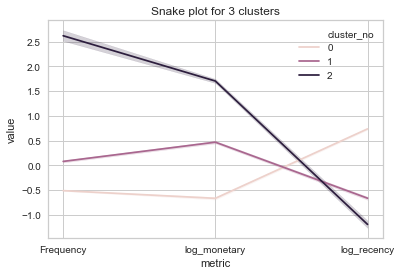

In [109]:
# Plot
plt.title("Snake plot for 3 clusters")
plt.xlabel("Metrics: log R,F,M")
plt.ylabel("Values")
sns.lineplot(data=rfm_melted, x='metric', y='value', hue='cluster_no');

### 4 Cluster K Means

In [110]:
kmeans_4 = KMeans(n_clusters=4, random_state=44)
kmeans_4.fit(scaled_rfm_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=44, tol=0.0001, verbose=0)

In [111]:
# Create column with each customer's cluster #
scaled_rfm_df_k4 = scaled_rfm_df.assign(cluster_no = kmeans_4.labels_)
scaled_rfm_df_k4

,log_monetary,log_recency,Frequency,cluster_no
Customer ID,,,,
12346.0,3.326315,0.843622,0.996487,3
12347.0,1.371182,-2.132447,0.391321,3
12348.0,0.606296,-0.080734,-0.062553,3
12349.0,1.191800,-0.960738,-0.213845,3
12350.0,-0.734414,0.813720,-0.667719,1
...,...,...,...,...
18283.0,0.832902,-1.949830,2.509401,2
18284.0,-0.493940,1.022332,-0.667719,1
18285.0,-0.552161,1.292326,-0.667719,1


In [112]:
# Silhouette score for K4
silhouette_score(scaled_rfm_df_k4, kmeans_4.labels_, metric='euclidean', random_state=44)

0.5206293544407026

In [113]:
gb_cluster_k4 = scaled_rfm_df_k4.groupby('cluster_no').agg({'log_recency': 'mean',\
                                                        'Frequency':'mean',\
                                                        'log_monetary': ['mean', 'count']})
gb_cluster_k4

log_recency Frequency log_monetary      
                  mean      mean         mean count
cluster_no                                         
0            -0.805416 -0.364498    -0.232542  1423
1             0.866116 -0.506609    -0.643554  2635
2            -1.384464  3.153937     1.802098   342
3            -0.465324  0.544206     0.990417  1424

In [114]:
rfm_melted_k4 = pd.melt(scaled_rfm_df_k4.reset_index(), # use this data, reset index
                    id_vars=['Customer ID', 'cluster_no'], # Cols to use as identifiers
                    value_vars=['log_recency', 'Frequency', 'log_monetary'], # Cols to unpivot- these will be row values now
                    var_name='metric', # Name for ^^
                     value_name='value') # Name for the values of ^^

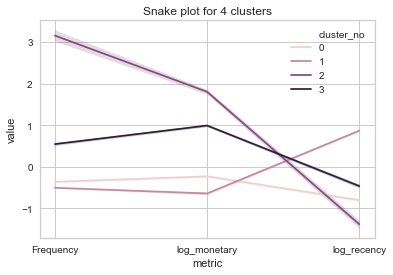

In [115]:
# Plot
plt.title("Snake plot for 4 clusters")
plt.xlabel("Metrics: log R,F,M")
plt.ylabel("Values")
sns.lineplot(data=rfm_melted_k4, x='metric', y='value', hue='cluster_no');

# KMeans-- quarterly clustering of cohort (first purchase = Q1 of 2010)
- Cohort 14 = those who's first purchase was january of second year of data (Jan 2011)

In [125]:
#df[(df['InvoiceMonth'] > '2011-01-01') & (df['InvoiceMonth'] < '2012-12-01')].describe()

### Isolate customers whos first purchase was Q1 of 2011

In [126]:
# Isolate first purchase between 1/2011 - 3/2011 (Q1 2011)
# df_cohort = df[(df['CohortMonth'] >= '2011-01-01') & (df['CohortMonth'] <= '2011-03-01')]
# Ended up not going with this start date ^^ because only 373 unique customers, vs 1200 for below

df_cohort = df[(df['CohortMonth'] >= '2010-01-01') & (df['CohortMonth'] <= '2010-03-01')]

In [127]:
df_cohort.CohortMonth.describe()

count                  186814
unique                      3
top       2010-01-01 00:00:00
freq                    66111
first     2010-01-01 00:00:00
last      2010-03-01 00:00:00
Name: CohortMonth, dtype: object

In [128]:
df_cohort['Customer ID'].nunique()

1202

In [129]:
df_cohort.shape

(186814, 12)

In [130]:
df_cohort['Customer ID'].nunique()

1202

In [131]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,InvoiceMonth,CohortMonth,Revenue,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2009-12-01,15.30,13
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2009-12-01,20.34,13
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2009-12-01,22.00,13
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2009-12-01,20.34,13
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2009-12-01,20.34,13


In [134]:
df_cohort_q1 = df_cohort[(df_cohort.InvoiceDate.dt.quarter == 1)
                         & (df_cohort['InvoiceDate'].dt.year == 2010)]
df_cohort_q12 = df_cohort[(df_cohort.InvoiceDate.dt.quarter <= 2)
                          & (df_cohort['InvoiceDate'].dt.year == 2010)]
df_cohort_q123 = df_cohort[(df_cohort.InvoiceDate.dt.quarter <= 3)
                           & (df_cohort['InvoiceDate'].dt.year == 2010)]
df_cohort_q1234 = df_cohort[(df_cohort.InvoiceDate.dt.quarter <= 4)
                            & (df_cohort['InvoiceDate'].dt.year == 2010)]

print(df_cohort_q1.shape, df_cohort_q12.shape, df_cohort_q123.shape,
      df_cohort_q1234.shape)

(39426, 12) (63863, 12) (87851, 12) (116994, 12)


In [135]:
df_cohort_q1.InvoiceDate.describe()

count                   39426
unique                   1748
top       2010-03-07 15:34:00
freq                      270
first     2010-01-04 10:43:00
last      2010-03-31 15:42:00
Name: InvoiceDate, dtype: object

In [136]:
# # For cohort 14 customers, create quarterly DFs to do analysis on
# df_coh14_q1 = df_coh14[df_coh14.InvoiceDate.dt.quarter == 1]
# df_coh14_q12 = df_coh14[df_coh14.InvoiceDate.dt.quarter <= 2]
# df_coh14_q123 = df_coh14[df_coh14.InvoiceDate.dt.quarter <= 3]
# df_coh14_q1234 = df_coh14[df_coh14.InvoiceDate.dt.quarter <= 4]

# # Check shape of each
# print(df_coh14.shape, df_coh14_q1.shape, df_coh14_q2.shape, df_coh14_q3.shape, df_coh14_q4.shape)

### Create R,F,M values for each new df

In [137]:
# Recency. Set End of Year date to calc recency.
eoy_date = pd.datetime(2011,12,10)

In [138]:
def RFM(df):
    ''' Function that does all the Recency, Frequency, Monetary value calcs at once.'''
    # Recency
    # Groupby Customer ID + get most recent/max invoice date
    recency = df.groupby('Customer ID', as_index=False)['InvoiceDate'].max()
    recency.columns = ['Customer ID', 'Last_Purchase_Date']
    
    recency['Recency'] = recency['Last_Purchase_Date'].apply(lambda x: (eoy_date - x).days)
    recency.drop('Last_Purchase_Date', axis=1,inplace=True)
    
    # Frequency
    frequency = df.groupby('Customer ID', as_index=False).agg({'Invoice': 'nunique'})
    frequency.head()
    
    # Monetary
    monetary = df.groupby('Customer ID', as_index=False)['Revenue'].sum()
    
    # Combine all into RFM table, rename columns
    rfm_table = recency.merge(frequency.merge(monetary,on='Customer ID'),on='Customer ID')
    rfm_table.rename(columns={'Customer ID': 'Customer ID', 'Recency': 'Recency', 'Invoice':'Frequency',\
                          'Revenue': 'Monetary'}, inplace=True)
    
    # Keep Customer ID in index
    rfm_table.set_index('Customer ID', inplace=True)
    
    # Make sure all values above 0 so we don't have issues with log
    rfm_table = rfm_table[rfm_table.Recency > 0]
    rfm_table = rfm_table[rfm_table.Frequency > 0] 
    rfm_table = rfm_table[rfm_table.Monetary > 0]
    
    # Log transform R,F,M so they are not as skewed
    # (For this multi quarter analysis I decided to log all of them)
    rfm_table['log_recency'] = np.log(rfm_table['Recency'])
    rfm_table['log_frequency'] = np.log(rfm_table['Frequency'])
    rfm_table['log_monetary'] = np.log(rfm_table['Monetary'])
    
    # RFM Scores/ Totals for EDA
    
    # Frequency quartile
    frequency_quartile = pd.qcut(rfm_table.Frequency, q=5, duplicates='drop', labels=range(1,5))
    
    # Recency quartile-- backwards coded because high recency is bad
    recency_labels = list(range(4, 0, -1)) # Backwards step w/ -1
    recency_quartile = pd.qcut(rfm_table['Recency'], q=4, labels=recency_labels)  
    
    # Monetary quartile
    monetary_quartile = pd.qcut(rfm_table['Monetary'], q=4, labels=range(1,5))

    # Turn quartiles into columns
    rfm_table['R'] = recency_quartile
    rfm_table['F'] = frequency_quartile
    rfm_table['M'] = monetary_quartile

    # RFM total
    def rfm_join(x):
        ''' Concats the R,F, and M cols '''
        return str(x['R']) + str(x['F']) + str(x['M']) 

    rfm_table['RFM_total'] = rfm_table.apply(rfm_join, axis=1)

    rfm_table['RFM_score'] = rfm_table[['R','F','M']].sum(axis=1)
    
    
    return rfm_table

In [148]:
# RFM_cohort_q1 = RFM(df_cohort_q1)
# RFM_cohort_q12 = RFM(df_cohort_q12)
RFM_cohort_q123 = RFM(df_cohort_q123)
RFM_cohort_q1234 = RFM(df_cohort_q1234)

In [149]:
x = pd.qcut(RFM_cohort_q1234.Frequency, q=5, duplicates='drop', labels=range(1,5))

In [150]:
frequency_quartile = pd.qcut(rfm_table['Frequency'], q=5, duplicates='drop', labels=range(1,5))

In [161]:
# model = KMeans()
# visualizer = KElbowVisualizer(model, k=(1,10),timings=False)

# visualizer.fit(RFM_cohort_q1234)        # Fit the data to the visualizer
# visualizer.show()        # Finalize and render the figure

### KMeans

In [157]:
# test k means for 1234 to ensure function output is correct
s = StandardScaler()
scaled = scaler.fit_transform(RFM_cohort_q1234)
scaled_df_test = pd.DataFrame(data=scaled, index=RFM_cohort_q1234.index, columns=RFM_cohort_q1234.columns)
#scaled_df.std(axis=0)

k = KMeans(n_clusters=3, random_state=44)
k.fit(scaled_df_test)
cluster_numbers = k.labels_
scaled_df_test['cluster_number'] = cluster_numbers

silhouette_score(scaled_df_test, cluster_numbers, metric='euclidean', random_state=44)

0.4689426668055114

In [158]:
silhouette_score(scaled_df_test, cluster_numbers, metric='euclidean', random_state=44)

0.4689426668055114

In [1055]:
def kmeans_cumulative(df, k):
    # Keep only relevant cols
    df = df[['log_recency', 'Frequency', 'log_monetary']] # Can get revenue back from log_monetary later
    
    # Scale / prep for clustering
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df)
    # Create a new df of scaled data (optional, can remove)
    scaled_df = pd.DataFrame(data=scaled, index=df.index, columns=df.columns)
    
    # KMeans
    kmeans = KMeans(n_clusters=k, random_state=44)
    kmeans.fit(scaled_df)
    cluster_labels = kmeans.labels_

    # Create column with each customer's cluster #
    scaled_df['cluster_no'] = cluster_labels

#     # Group by cluster and examine each cluster's mean R,F,M values. Get count.
#     gb_cluster = scaled_rfm_df_k3.groupby('cluster_no').agg({'log_recency': 'mean',\
#                                                         'Frequency':'mean',\
#                                                         'log_monetary': ['mean', 'count']})
    return scaled_df, cluster_labels

In [1109]:
# Run KMeans for each quarter cumulative
kmeans_cohort_q1 = kmeans_cumulative(RFM_cohort_q1,3)[0]
kmeans_cohort_q1_labels = kmeans_cumulative(RFM_cohort_q1,3)[1]

kmeans_cohort_q12 = kmeans_cumulative(RFM_cohort_q12,3)[0]
kmeans_cohort_q12_labels = kmeans_cumulative(RFM_cohort_q12,3)[1]

kmeans_cohort_q123 = kmeans_cumulative(RFM_cohort_q123,3)[0] # Elbow rec is 4 for this grouping
kmeans_cohort_q123_labels = kmeans_cumulative(RFM_cohort_q123,3)[1] # Elbow rec is 4 for this grouping

kmeans_cohort_q1234 = kmeans_cumulative(RFM_cohort_q1234,3)[0]
kmeans_cohort_q1234_labels = kmeans_cumulative(RFM_cohort_q1234,3)[1]

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning:

Data with input dty

In [1111]:
kmeans_cohort_q123

,log_recency,Frequency,log_monetary,cluster_no
Customer ID,,,,
12360.0,0.265071,-0.137152,0.084160,2
12361.0,-0.986762,-0.137152,-0.681800,2
12366.0,1.007066,-0.728110,-0.299554,0
12368.0,0.956856,-0.728110,0.224536,0
12369.0,-1.167477,-0.432631,0.708868,2
...,...,...,...,...
18257.0,-1.209923,0.158328,1.003926,2
18267.0,1.385614,-0.728110,-0.834199,0
18272.0,0.094093,-0.137152,0.530228,2


### Pickle final cumulative df for time-series on each cluster

#### Silhouette scores for each kmeans

In [1077]:
kmeans_cohort_q1234

,log_recency,Frequency,log_monetary,cluster_no
Customer ID,,,,
12360.0,-0.972768,0.126404,0.450687,1
12361.0,-0.078621,-0.331857,-0.884608,1
12366.0,1.343252,-0.790118,-0.515148,0
12368.0,1.307445,-0.790118,-0.008587,0
12369.0,-0.584857,-0.331857,0.549699,1
...,...,...,...,...
18257.0,-0.237765,-0.102727,0.744733,1
18267.0,1.613209,-0.790118,-1.031909,0
18272.0,0.692177,-0.331857,0.286880,1


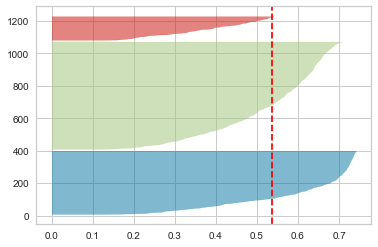

In [1268]:
# Instantiate the clustering model and visualizer
model = KMeans(3, random_state=44)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(kmeans_cohort_q1234);

In [1270]:
visualizer.silhouette_score_

0.5357580062173894

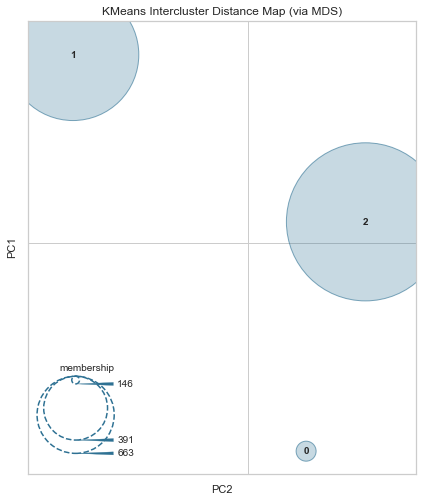

In [1267]:
from yellowbrick.cluster import InterclusterDistance

# Instantiate the clustering model and visualizer
model = KMeans(3,random_state=33)
visualizer = InterclusterDistance(model, random_state=44,size=(500,600))

visualizer.fit(kmeans_cohort_q1234)        # Fit the data to the visualizer
# visualizer.show();        # Finalize and render the figure
visualizer.show(outpath="kmeans_distance.png");

In [1100]:
visualizer.scores_ # Size of clusters-- good to use to link the visual's cluster numbering to manual kmeans

array([146, 391, 663])

In [1101]:
print(
    silhouette_score(kmeans_cohort_q1,
                     kmeans_cohort_q1_labels,
                     metric='euclidean',
                     random_state=44))
print(
    silhouette_score(kmeans_cohort_q12,
                     kmeans_cohort_q12_labels,
                     metric='euclidean',
                     random_state=44))
print(
    silhouette_score(kmeans_cohort_q123,
                     kmeans_cohort_q123_labels,
                     metric='euclidean',
                     random_state=44))
print(
    silhouette_score(kmeans_cohort_q1234,
                     kmeans_cohort_q1234_labels,
                     metric='euclidean',
                     random_state=44))

0.485097245339666
0.5279323266888493
0.5587573304992859
0.5357580062173894


In [1102]:
print(kmeans_cohort_q1.shape)
print(kmeans_cohort_q12.shape)
print(kmeans_cohort_q123.shape)
print(kmeans_cohort_q1234.shape)

(1200, 4)
(1200, 4)
(1200, 4)
(1200, 4)


### Analyze each quarter's RFM+KMeans

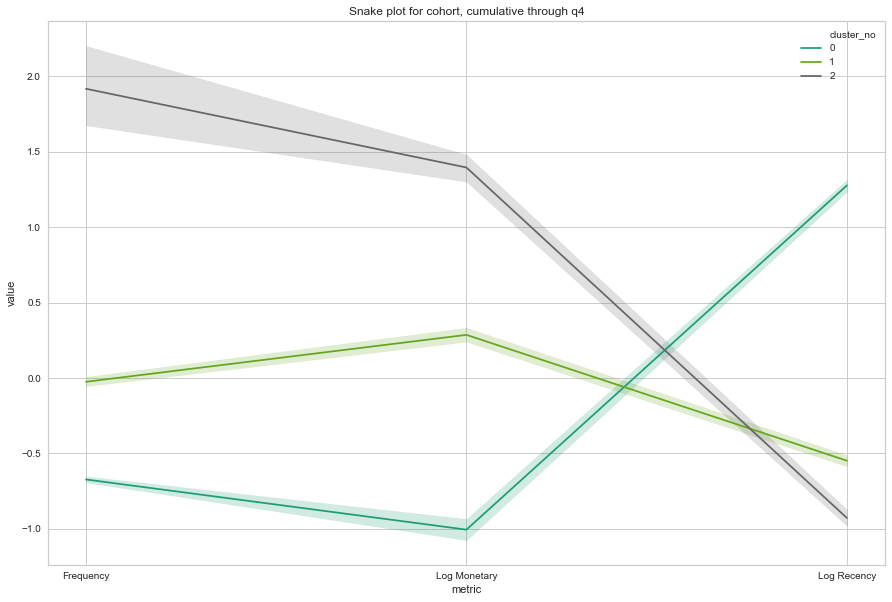

In [1259]:
gb_cluster_q1234 = kmeans_cohort_q1234.groupby('cluster_no').agg({'log_recency': 'mean',\
                                                        'Frequency':'mean',\
                                                        'log_monetary': ['mean', 'count']})
# gb_cluster_coh14_q1234

melted_q1234 = pd.melt(kmeans_cohort_q1234.reset_index(), # use this data, reset index
                    id_vars=['cluster_no', 'Customer ID'], # Cols to use as identifiers
                    value_vars=['log_recency', 'Frequency', 'log_monetary'], # Cols to unpivot- these will be row values now
                    var_name='metric', # Name for ^^
                     value_name='value') # Name for the values of ^^


# Plot
plt.figure(figsize=(15,10))
plt.title("Snake plot for cohort, cumulative through q4")
plt.xlabel("Metrics: log R,F,M")
plt.ylabel("Values")
pl = sns.lineplot(data=melted_q1234, x='metric', y='value', hue='cluster_no',palette='Dark2')
pl.set(xticklabels=['Frequency', 'Log Monetary', 'Log Recency']);

plt.savefig('SnakePlot.png')




In [1104]:
gb_cluster_q1234

log_recency Frequency log_monetary      
                  mean      mean         mean count
cluster_no                                         
0             1.276510 -0.672916    -1.005451   391
1            -0.548451 -0.025313     0.285740   663
2            -0.928028  1.917074     1.395107   146

In [1094]:
# gb_cluster_q123 = kmeans_cohort_q123.groupby('cluster_no').agg({'log_recency': 'mean',\
#                                                         'Frequency':'mean',\
#                                                         'log_monetary': ['mean', 'count']})
# # gb_cluster_coh14_q1234

# melted_q123 = pd.melt(kmeans_cohort_q123.reset_index(), # use this data, reset index
#                     id_vars=['cluster_no'], # Cols to use as identifiers
#                     value_vars=['log_recency', 'Frequency', 'log_monetary'], # Cols to unpivot- these will be row values now
#                     var_name='metric', # Name for ^^
#                      value_name='value') # Name for the values of ^^


# # Plot
# plt.title("Snake plot for cohort 2011, q1-3")
# plt.xlabel("Metrics: log R,F,M")
# plt.ylabel("Values")
# sns.lineplot(data=melted_q123, x='metric', y='value', hue='cluster_no');

# Pickle kmeans dfs to work on time-series

In [1095]:
kmeans_cohort_q1234.cluster_no.value_counts()

1    663
0    391
2    146
Name: cluster_no, dtype: int64

In [1096]:
gb = kmeans_cohort_q1234.groupby('cluster_no').agg({'log_recency': 'mean', 'Frequency': 'mean', 'log_monetary': ['mean','count']})
gb

log_recency Frequency log_monetary      
                  mean      mean         mean count
cluster_no                                         
0             1.276510 -0.672916    -1.005451   391
1            -0.548451 -0.025313     0.285740   663
2            -0.928028  1.917074     1.395107   146

In [1097]:
# import pickle
with open ('kmeans_cohort_q123.pickle', 'wb') as to_write:
    pickle.dump(kmeans_cohort_q123, to_write)
    
with open ('kmeans_cohort_q1234.pickle', 'wb') as to_write:
    pickle.dump(kmeans_cohort_q1234, to_write)
    

    
# # # To load pickle back in
# # with open('df_cleaned.pickle','rb') as read_file:
# #     df = pickle.load(read_file)

# Other Clustering

### DBSCAN Prep

In [272]:
dbscan_rfm_table = dbscan_rfm_table[['log_monetary', 'log_recency', 'log_frequency']]
dbscan_rfm_table.head()

,log_monetary,log_recency,log_frequency
Customer ID,,,
12346.0,11.258761,5.786897,2.484907
12347.0,8.636454,1.098612,2.079442
12348.0,7.610556,4.330733,1.609438
12349.0,8.395859,2.944439,1.386294
12350.0,5.812338,5.739793,0.000000


In [273]:
# Scale data
scaler = StandardScaler()
scaled_dbscan_rfm_table = scaler.fit_transform(dbscan_rfm_table)
scaled_dbscan_rfm_table_df = pd.DataFrame(data=scaled_dbscan_rfm_table,
                                          index=dbscan_rfm_table.index,
                                          columns=dbscan_rfm_table.columns)
scaled_dbscan_rfm_table_df.head()

,log_monetary,log_recency,log_frequency
Customer ID,,,
12346.0,3.180080,0.849280,1.247093
12347.0,1.295493,-2.089437,0.852873
12348.0,0.558205,-0.063475,0.395905
12349.0,1.122583,-0.932434,0.178951
12350.0,-0.734129,0.819754,-1.168894


In [278]:
# Check scaling
print(scaled_dbscan_rfm_table_df.mean(axis=0))
print(scaled_dbscan_rfm_table_df.std(axis=0))

log_monetary     2.066700e-16
log_recency     -6.355734e-17
log_frequency    1.834758e-16
dtype: float64
log_monetary     1.000085
log_recency      1.000085
log_frequency    1.000085
dtype: float64


### DBSCAN Clustering

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

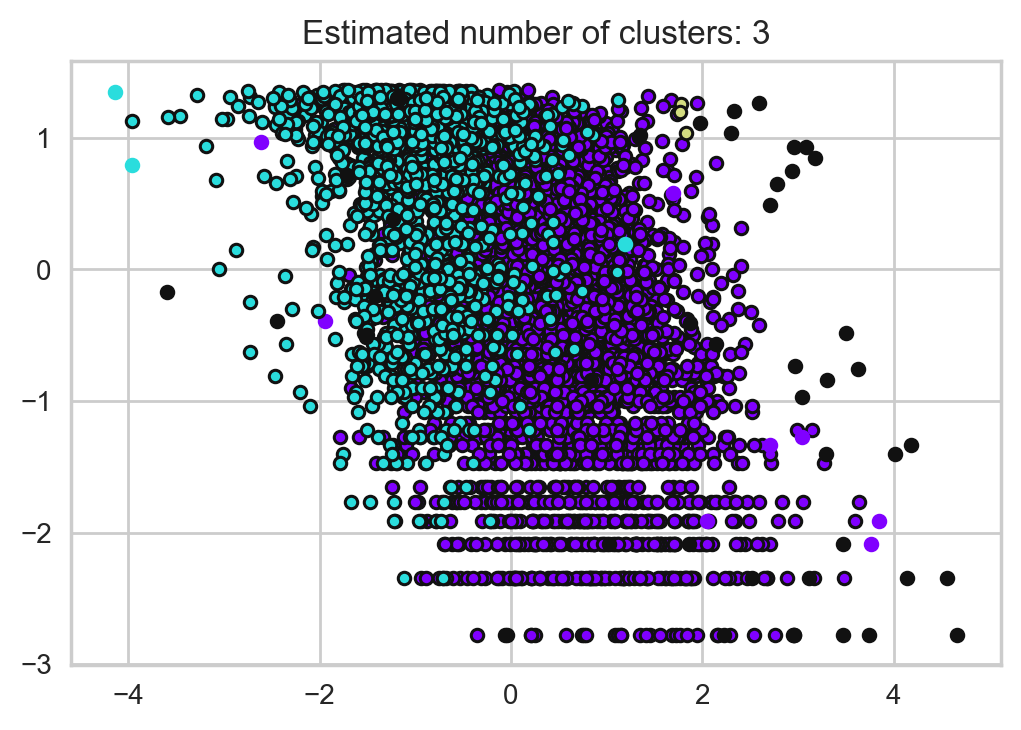

In [294]:
# Fit DBSCAN

db = DBSCAN(eps=0.5, min_samples=3).fit(scaled_dbscan_rfm_table)

# Let's find the observations DBSCAN called "core"
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

unique_labels = set(labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
plt.figure(dpi=200)
show_core = True
show_non_core = True
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)
    if show_core:
        xy = scaled_dbscan_rfm_table[class_member_mask & core_samples_mask]
        x, y = xy[:,0], xy[:,1]
        plt.scatter(x, y, c=col, edgecolors='k',  s=20, linewidths=1.1) # add black border for core points
    
    if show_non_core:
        xy = scaled_dbscan_rfm_table[class_member_mask & ~core_samples_mask]
        x, y = xy[:,0], xy[:,1]
        plt.scatter(x, y, c=col, s=20, linewidths=1.1)

plt.title('Estimated number of clusters: %d' % n_clusters_);

In [286]:
def dbscan(X, eps, min_samples):
    ss = StandardScaler()
    X = ss.fit_transform(X)
    db = DBSCAN(eps=eps, min_samples=min_samples)
    db.fit(X)
    y_pred = db.fit_predict(X)
    plt.scatter(X[:,0], X[:,1],c=y_pred, cmap='Paired')
    plt.title("DBSCAN")

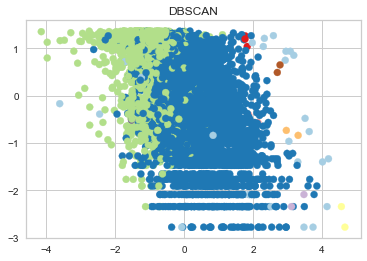

In [292]:
dbscan(scaled_dbscan_rfm_table,.5,2)

In [500]:
kmeans_coh14_q1234

,log_recency,Frequency,log_monetary,cluster_no
Customer ID,,,,
12346.0,0.674721,-0.374149,5.289127,2
12356.0,-1.796774,-0.374149,-1.848942,0
12359.0,0.691511,-0.374149,0.374569,1
12361.0,0.560596,-0.374149,-0.677016,1
12370.0,0.518051,-0.374149,0.909668,1
...,...,...,...,...
18241.0,0.303987,-0.374149,-0.025853,1
18260.0,0.699792,-0.374149,0.391778,1
18270.0,-1.295144,-0.374149,-0.779969,0


# Relative importance of each metric

### Relative importance of each metric (RFM values for each cluster, compared to overall)

In [502]:
# these might need to be unlogged for overall avg + cluster avg to be on sampe plane

In [501]:
cluster_avg = kmeans_coh14_q1234.groupby(['cluster_no']).mean() 
cluster_avg

,log_recency,Frequency,log_monetary
cluster_no,,,
0,-1.850101,-0.190902,-0.248925
1,0.412556,-0.204854,-0.073569
2,0.287115,3.008598,1.592714


In [147]:
overall_avg = scaled_rfm_df[['Recency', 'Frequency', 'log_monetary']].mean()
overall_avg

Recency         4.670945e-17
Frequency       2.905671e-16
log_monetary    2.066700e-16
dtype: float64

In [138]:
relative_imp = cluster_avg / overall_avg - 1
relative_imp

,Recency,Frequency,log_monetary
cluster_no,,,
0,-1.281233e+16,-3.372544e+14,6.724635e+14
1,2.611247e+16,-1.157886e+15,-3.480810e+15
2,-1.727490e+16,6.442450e+15,8.794547e+15


(3.5, -0.5)

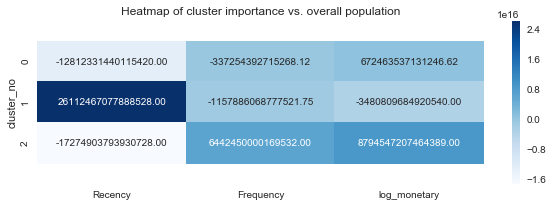

In [142]:
# Plot heatmap of relative importance
plt.figure(figsize=(10,3))
plt.title("Heatmap of cluster importance vs. overall population")
ax = sns.heatmap(data=relative_imp, annot=True, cmap='Blues', fmt='.2f')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + .5, top -.5)